### **Load libraries**

In [2]:
import sys
sys.path.append('../src')
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout
import importlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR
from mgarch import mgarch

import itertools
import random

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Load data**

In [4]:
rets = pd.read_csv('all_rets.csv', index_col=0)
stocks = pd.read_csv('all_stocks.csv', index_col=0)
selected_stocks = pd.read_csv('selected_stocks_rets.csv', index_col=0).columns

rets.index = pd.to_datetime(rets.index).to_period('W')
stocks.index = pd.to_datetime(stocks.index).to_period('W')

In [5]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 54

# **Estimation of future Moving Average Returns**

## **Analysis of stationarity**

In [6]:
# Analysis of stationarity for the whole series
for stock in rets.columns:
    print(f'Augmented Dickey Fuller Test p-value for non-stationarity of level {stock} series: {round(adfuller(rets[stock])[1], 4)}')

# All return series are stationary, however, differentiating by first order seems to result in better models

Augmented Dickey Fuller Test p-value for non-stationarity of level BCOLOMBIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BOGOTA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BVC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CELSIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CEMARGOS.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CNEC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CONCONCRET.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CORFICOLCF.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ECOPETROL.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ENKA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ETB.CL series: 0.0
Augmented Dicke

## **Model 1: Annualized Yearly Returns from the Last 3 Years**

In [7]:
# Compare with the expected returns calculated from historical returns
historical_annualized_returns = rk.summary_stats(rets.iloc[-162:], periods_per_year=periods_per_year)['Annualized Return']
historical_annualized_returns

BCOLOMBIA.CL     0.196458
BOGOTA.CL       -0.108492
BVC.CL           0.174349
CELSIA.CL        0.101479
CEMARGOS.CL      0.315029
CNEC.CL         -0.466641
CONCONCRET.CL    0.165547
CORFICOLCF.CL   -0.081452
ECOPETROL.CL    -0.131910
ENKA.CL         -0.056978
ETB.CL          -0.306639
EXITO.CL        -0.076208
GEB.CL           0.217318
GRUBOLIVAR.CL   -0.010748
GRUPOARGOS.CL    0.266208
GRUPOAVAL.CL    -0.092334
GRUPOSURA.CL     0.067143
HCOLSEL.CL       0.081251
ICOLCAP.CL       0.057912
ISA.CL           0.013367
MINEROS.CL       0.309609
NUTRESA.CL       0.551035
PFAVAL.CL       -0.077198
PFBCOLOM.CL      0.166211
PFCORFICOL.CL   -0.012538
PFDAVVNDA.CL    -0.137330
PFGRUPOARG.CL    0.332114
PFGRUPSURA.CL    0.301741
PROMIGAS.CL      0.033981
TERPEL.CL        0.243489
AAPL             0.140760
AMZN             0.220167
BAC              0.122555
BRK-B            0.154336
C                0.240458
CBU7.L           0.024961
CENCOSUD.SN      0.377824
CHILE.SN         0.251404
CSPX.L      

## **Model 2: VAR bagging**

In [8]:
# Get the 1st order integration for the returns series
rets_integrated = (rets - rets.shift(1)).dropna()

In [9]:
symbols_list = list(rets.columns.values) # List of all available stock symbols
n_iterations = 2000 # The number of iterations of VAR models to perform
set_size = 10 # Number of symbols modeled in each iteration
periods_to_forecast = 4 # Number of periods to forecast

# Initialize an empty list of sets of stock symbols
iterations_symbols = []

for i in range(n_iterations):
    # For each iteration of the model, select a random set of 'set_size' stock symbols
    iterations_symbols.append(random.sample(symbols_list, set_size))

In [10]:
# Initialize a dictionary of dictionaries where the results of each iteration will be stored
prediction_results = {symbol: {} for symbol in symbols_list}

for i, symbols_selection in enumerate(iterations_symbols):
    # In each iteration, generate a dataset with the stocks selected for the iteration only
    subset_df = rets_integrated[symbols_selection]
    
    # Compare the IC (Information Criteria) scores for VAR models of various number of lags to select the ideal number of lags
    varmod = VAR(subset_df)
    lag_sel = varmod.select_order(10)
    
    # Select the best number of lags according to the AIC criterion
    n_lags = lag_sel.aic
    print(f'Iteration {i}, ideal_n_lags: {n_lags}')
    
    # Fit the model for the iteration
    var_model = VAR(subset_df).fit(maxlags=n_lags, trend='c')

    # Predict the following 'periods_to_forecast' periods
    predictions = var_model.forecast(subset_df.iloc[-n_lags:].values, periods_to_forecast)
    predictions = pd.DataFrame(predictions)

    # Append the predicted values to the 'prediction_results' dictionary
    for l in predictions:
        prediction_results[symbols_selection[l]][i] = predictions[l]
    print(f'Iteration {i+1} finished')

Iteration 0, ideal_n_lags: 9
Iteration 1 finished
Iteration 1, ideal_n_lags: 9
Iteration 2 finished
Iteration 2, ideal_n_lags: 8
Iteration 3 finished
Iteration 3, ideal_n_lags: 7
Iteration 4 finished
Iteration 4, ideal_n_lags: 8
Iteration 5 finished
Iteration 5, ideal_n_lags: 10
Iteration 6 finished
Iteration 6, ideal_n_lags: 9
Iteration 7 finished
Iteration 7, ideal_n_lags: 6
Iteration 8 finished
Iteration 8, ideal_n_lags: 8
Iteration 9 finished
Iteration 9, ideal_n_lags: 7
Iteration 10 finished
Iteration 10, ideal_n_lags: 6
Iteration 11 finished
Iteration 11, ideal_n_lags: 9
Iteration 12 finished
Iteration 12, ideal_n_lags: 8
Iteration 13 finished
Iteration 13, ideal_n_lags: 8
Iteration 14 finished
Iteration 14, ideal_n_lags: 8
Iteration 15 finished
Iteration 15, ideal_n_lags: 8
Iteration 16 finished
Iteration 16, ideal_n_lags: 7
Iteration 17 finished
Iteration 17, ideal_n_lags: 7
Iteration 18 finished
Iteration 18, ideal_n_lags: 9
Iteration 19 finished
Iteration 19, ideal_n_lags: 7


In [11]:
import warnings
warnings.filterwarnings('ignore')

# Copy the 'prediction_results' dictionary to invert the integration of the copy and set the index for predicted dates
prediction_results_processed = prediction_results.copy()
for symbol in prediction_results:
    # For each stock in 'prediction_results', convert the predictions into a dataframe
    pred_df = pd.DataFrame(prediction_results[symbol])

    # Get the average predictions for each day
    pred_series = pred_df.mean(axis=1)

    # Invert the integration by taking the last actual returns and add it to the predictions, then do a cumulative sum
    pred_series = rets[symbol][-1] + pred_series.cumsum()
    
    # Generate an index for the future dates
    #future_dates = pd.date_range(start=rets.index.max().to_timestamp() + pd.Timedelta(value=1, unit='d'), periods=periods_to_forecast)
    future_dates = pd.date_range(start=rets.index.max().to_timestamp() + pd.Timedelta(value=7, unit='d'), periods=periods_to_forecast, freq='W-SUN').to_period('W') # Weekly
    pred_series.index = future_dates
    
    # Add the series of average predicted returns for the stock to the 'prediction_results_processed' dictionary
    prediction_results_processed[symbol] = pred_series

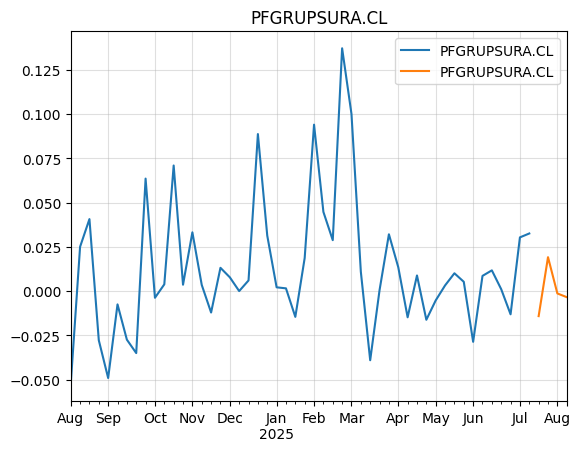

In [12]:
# Visualize the predictions of any stock
symbol = 'PFGRUPSURA.CL'
concat_df = pd.concat([rets[symbol][-50:], pd.DataFrame(prediction_results_processed[symbol], columns=[symbol])], axis=1)

concat_df.plot()
#prediction_results_processed[symbol].plot()
plt.grid(alpha=.4)
plt.title(symbol)
plt.show()

In [13]:
# Calculate the exptected annual returns for each stock
# Initialize an empty dictionary where the returns will be stored
expected_annualized_rets = {}

for symbol in prediction_results_processed:
    # Calculate the weighted average returns from the predictions and then annualize them
    # Uncomment the method of weighting for the averaging and annualization of the returns
    
    ### Raw predicted returns annualized
    # expected_annualized_returns = ((prediction_results_processed[symbol] + 1).prod()**(1/len(prediction_results_processed[symbol])))**(periods_per_year) - 1
    
    ### Linearly decaying weighted returns annualized
    # weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    # linear_decay_w = (periods_to_forecast - weight_indexes + 1)/weight_indexes.sum()
    # expected_annualized_returns = (1 + np.sum(prediction_results_processed[symbol]*linear_decay_w))**periods_per_year - 1

    ### Exponentially decaying weighted returns annualized
    weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    lambda_ = 0.2
    exponential_decay_w = np.exp(-lambda_*weight_indexes)/np.exp(-lambda_*weight_indexes).sum()
    expected_annualized_returns = (1 + np.sum(prediction_results_processed[symbol]*exponential_decay_w))**periods_per_year - 1

    expected_annualized_rets[symbol] = expected_annualized_returns

In [14]:
# Predictions of annualized returns for the VAR Bagging model
var_bagging_expected_annualized_rets = expected_annualized_rets
pd.Series(var_bagging_expected_annualized_rets)

BCOLOMBIA.CL    -0.182775
BOGOTA.CL       -0.024073
BVC.CL          -0.409606
CELSIA.CL        0.426559
CEMARGOS.CL      0.110768
CNEC.CL         -0.714493
CONCONCRET.CL   -0.701442
CORFICOLCF.CL   -0.132672
ECOPETROL.CL    -0.290710
ENKA.CL         -0.045080
ETB.CL           0.653405
EXITO.CL         5.728432
GEB.CL           0.316742
GRUBOLIVAR.CL    0.154981
GRUPOARGOS.CL    0.557827
GRUPOAVAL.CL    -0.329434
GRUPOSURA.CL     1.179301
HCOLSEL.CL      -0.066508
ICOLCAP.CL       0.026041
ISA.CL          -0.374349
MINEROS.CL       0.220063
NUTRESA.CL       0.114766
PFAVAL.CL       -0.353693
PFBCOLOM.CL     -0.172102
PFCORFICOL.CL   -0.124190
PFDAVVNDA.CL    -0.107838
PFGRUPOARG.CL    0.326031
PFGRUPSURA.CL   -0.022024
PROMIGAS.CL      0.031271
TERPEL.CL        0.134241
AAPL             0.254143
AMZN             1.093779
BAC              0.440398
BRK-B           -0.483015
C                2.033673
CBU7.L           0.133573
CENCOSUD.SN     -0.171203
CHILE.SN        -0.269592
CSPX.L      

## **Model 3: Transformer Neural Network**

### **Generate the data**

In [15]:
data = rets.values

# Prepare the data for training
def create_dataset(data, time_window=1):
    X, Y = [], []

    for i in range(len(data)-time_window):
        X.append(data[i:(i+time_window)])
        Y.append(data[i + time_window])
    return np.array(X), np.array(Y)

# Generate the sequences of data
time_window = 54
X, Y = create_dataset(data, time_window)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (467, 54, 54)
Shape of Y: (467, 54)


### **Implement Positional Encoding**

In [16]:
# Positional encoding represents the data in time steps
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super().__init__()
        self.sequence_length = sequence_length
        self.d_model = d_model

    def call(self, inputs):
        positions = np.arange(self.sequence_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.d_model, 2) * (-np.log(10000.0) / self.d_model))
        pos_encoding = np.zeros((self.sequence_length, self.d_model))
        pos_encoding[:, 0::2] = np.sin(positions * div_term)
        pos_encoding[:, 1::2] = np.cos(positions * div_term)
        return inputs + tf.convert_to_tensor(pos_encoding, dtype=tf.float32)

### **Implement the Transformer Encoder block**

In [17]:
# Implement Multi-Head Self-Attention, Layer Normalization, and Feed-Forward Networks
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Self-Attention
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-Forward Network
    ff_output = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    return x

### **Build the Transformer Model**

In [18]:
# Function that builds the model that will take inputs, encode them, and then make a prediction for the input_shape[1] items
def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=128, num_transformer_blocks=2, dropout=0.1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Positional Encoding
    x = PositionalEncoding(sequence_length=input_shape[0], d_model=input_shape[1])(inputs)
    
    # Transformer Encoder Blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Global Average Pooling over time dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Output Layer (input_shape[1]-dimensional vector)
    outputs = tf.keras.layers.Dense(input_shape[1])(x)

    # Build Model
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="mse",
        metrics=["mae", tf.keras.metrics.RootMeanSquaredError]
    )
    
    return model

### **Train the Model**

In [19]:
input_shape = (time_window, X.shape[2]) # Shape of each input
head_size = 128
num_heads = 8
ff_dim = 512
num_transformer_blocks = 6
dropout = 0.1

model = build_transformer_model(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 54, 54)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ positional_encoding           │ (None, 54, 54)            │               0 │ input_layer[0][0]          │
│ (PositionalEncoding)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 54, 54)            │          56,118 │ positional_encoding[0][0], │
│ (MultiHeadAttention)          │                           │                 │ positional_encoding[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 54, 54)            │               0 │ multi_head_attention[0][0… │
│                               │                           │                 │ positional_encoding[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 54, 54)            │             108 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 54, 128)           │           7,040 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 54, 54)            │           6,966 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 54, 54)            │               0 │ layer_normalization[0][0], │
│                               │                           │                 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 54, 54)            │             108 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 54, 54)            │          56,118 │ layer_normalization_1[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 54, 54)            │               0 │ multi_head_attention_1[0]… │
│                               │                           │                 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 54, 54)            │             108 │ add_2[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 54, 128)           │           7,04

 Total params: 143,650 (561.13 KB)

 Trainable params: 143,650 (561.13 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
history = model.fit(
    X, Y,
    epochs=50,
    batch_size=32
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.4675 - mae: 0.5321 - root_mean_squared_error: 0.6814
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1384 - mae: 0.2814 - root_mean_squared_error: 0.3710
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0485 - mae: 0.1712 - root_mean_squared_error: 0.2199
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0217 - mae: 0.1169 - root_mean_squared_error: 0.1471
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0117 - mae: 0.0832 - root_mean_squared_error: 0.1083
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0073 - mae: 0.0656 - root_mean_squared_error: 0.0855
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0053 - mae: 0.0544 - root_mean_squared_error: 0.0725
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0039 - mae: 0.0447 - root_mean_squared_error: 0.0621
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0031 - mae: 0.0400 - root_m

### **Perform predictions**

In [21]:
# Generate the input for the prediction of future period

# Add a dummy array for the future period,
# so that the generate_dataset function will capture the latest observation in the last sequence
data_preds = data.copy()
data_preds = np.concatenate((data_preds, np.expand_dims(np.zeros_like(data_preds[-1]), axis=0)))

X_, Y_ = create_dataset(data_preds, time_window)

In [22]:
periods_to_forecast = 4
preds = []
pred_inputs = np.expand_dims(X_[-1], axis=0)

for i in range(periods_to_forecast):
    prediction = model.predict(pred_inputs)
    preds.append(prediction[0])
    pred_inputs = np.concatenate((pred_inputs[0][1:], np.expand_dims(prediction[0], axis=0)))
    pred_inputs = np.expand_dims(pred_inputs, axis=0)

preds = np.array(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [23]:
preds_df = pd.DataFrame(preds, columns=rets.columns)

future_dates = pd.date_range(start=rets.index.max().to_timestamp() + pd.Timedelta(value=7, unit='d'), periods=periods_to_forecast, freq='W-SUN').to_period('W') # Weekly
preds_df = pd.DataFrame(preds, columns=rets.columns, index=future_dates)

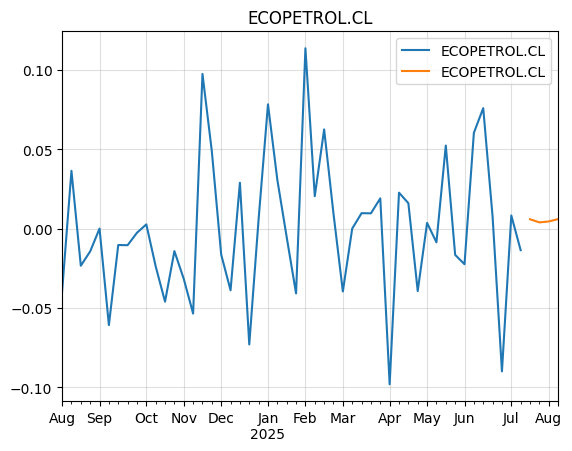

In [24]:
# Visualize the predictions of any stock
symbol = 'ECOPETROL.CL'#'PFGRUPSURA.CL'
concat_df = pd.concat([rets[symbol][-50:], preds_df[symbol]], axis=1)

concat_df.plot()
#prediction_results_processed[symbol].plot()
plt.grid(alpha=.4)
plt.title(symbol)
plt.show()

In [25]:
# Calculate the exptected annual returns for each stock
# Initialize an empty dictionary where the returns will be stored
expected_annualized_rets = {}

for symbol in preds_df.columns:
    # Calculate the weighted average returns from the predictions and then annualize them
    # Uncomment the method of weighting for the averaging and annualization of the returns
    
    ### Raw predicted returns annualized
    # expected_annualized_returns = ((prediction_results_processed[symbol] + 1).prod()**(1/len(prediction_results_processed[symbol])))**(periods_per_year) - 1
    
    ### Linearly decaying weighted returns annualized
    # weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    # linear_decay_w = (periods_to_forecast - weight_indexes + 1)/weight_indexes.sum()
    # expected_annualized_returns = (1 + np.sum(prediction_results_processed[symbol]*linear_decay_w))**periods_per_year - 1

    ### Exponentially decaying weighted returns annualized
    weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    lambda_ = 0.2
    exponential_decay_w = np.exp(-lambda_*weight_indexes)/np.exp(-lambda_*weight_indexes).sum()
    expected_annualized_returns = (1 + np.sum(preds_df[symbol]*exponential_decay_w))**periods_per_year - 1

    expected_annualized_rets[symbol] = expected_annualized_returns

In [26]:
# Predictions of annualized returns for the Transformer model
transformer_expected_annualized_rets = expected_annualized_rets
pd.Series(transformer_expected_annualized_rets)

BCOLOMBIA.CL     1.893482
BOGOTA.CL        0.506692
BVC.CL           0.337155
CELSIA.CL       -0.215965
CEMARGOS.CL     -0.357730
CNEC.CL         -0.378551
CONCONCRET.CL    0.774425
CORFICOLCF.CL   -0.632687
ECOPETROL.CL     0.313230
ENKA.CL          0.174208
ETB.CL           0.102411
EXITO.CL        -0.645252
GEB.CL          -0.274137
GRUBOLIVAR.CL    0.783820
GRUPOARGOS.CL   -0.097793
GRUPOAVAL.CL    -0.113478
GRUPOSURA.CL     0.562021
HCOLSEL.CL      -0.432097
ICOLCAP.CL      -0.357908
ISA.CL          -0.043258
MINEROS.CL      -0.126896
NUTRESA.CL       1.228650
PFAVAL.CL       -0.143601
PFBCOLOM.CL     -0.133105
PFCORFICOL.CL    1.972452
PFDAVVNDA.CL     0.077571
PFGRUPOARG.CL   -0.448508
PFGRUPSURA.CL   -0.079665
PROMIGAS.CL     -0.351668
TERPEL.CL       -0.140399
AAPL             0.178773
AMZN             1.842877
BAC              0.063145
BRK-B           -0.093345
C                0.036358
CBU7.L           0.062391
CENCOSUD.SN      0.494120
CHILE.SN        -0.110370
CSPX.L      

In [ ]:
# Compare returns of different models:
"""
pd.Series(historical_annualized_returns)
pd.Series(var_bagging_expected_annualized_rets)
pd.Series(transformer_expected_annualized_rets)
"""

# **Covariance matrix estimation**

## **Model 1: Historical Covariance Matrix from the last 3 years**

In [27]:
# Simple long-term covariance
covmat = rets.iloc[-periods_per_year * 3:].cov()
covmat

,BCOLOMBIA.CL,BOGOTA.CL,BVC.CL,CELSIA.CL,CEMARGOS.CL,CNEC.CL,CONCONCRET.CL,CORFICOLCF.CL,ECOPETROL.CL,ENKA.CL,ETB.CL,EXITO.CL,GEB.CL,GRUBOLIVAR.CL,GRUPOARGOS.CL,GRUPOAVAL.CL,GRUPOSURA.CL,HCOLSEL.CL,ICOLCAP.CL,ISA.CL,MINEROS.CL,NUTRESA.CL,PFAVAL.CL,PFBCOLOM.CL,PFCORFICOL.CL,PFDAVVNDA.CL,PFGRUPOARG.CL,PFGRUPSURA.CL,PROMIGAS.CL,TERPEL.CL,AAPL,AMZN,BAC,BRK-B,C,CBU7.L,CENCOSUD.SN,CHILE.SN,CSPX.L,EIMI.L,F,FALABELLA.SN,GE,GOOGL,JETS,JNJ,JPM,META,NKE,NVDA,PBR,PFE,SGLD.L,VOO
BCOLOMBIA.CL,0.002305,0.000603,0.000122,0.000383,0.000284,0.000409,0.000430,0.001136,0.000637,5.353673e-04,0.000069,0.000368,0.000383,0.000489,0.000427,0.000493,0.000284,0.000574,0.000820,7.839037e-04,0.000528,6.550912e-05,0.000896,0.001496,0.000934,0.000597,6.025894e-04,0.000688,0.000367,0.000335,-4.201608e-05,-0.000005,3.826724e-04,0.000216,5.407622e-04,3.529285e-05,0.000081,0.000250,0.000130,0.000314,0.000722,0.000055,0.000257,0.000029,1.442720e-04,0.000027,0.000321,7.503719e-05,0.000409,-1.981719e-04,0.000407,0.000049,1.214052e-04,0.000101
BOGOTA.CL,0.000603,0.002085,0.000019,0.000468,0.000071,0.000480,0.000514,0.000765,0.000156,-1.997173e-04,0.000063,0.000432,0.000585,0.000331,0.000151,0.000412,-0.000202,0.000333,0.000466,1.641821e-04,0.000153,1.816939e-04,0.000780,0.000596,0.000334,0.000423,1.485030e-04,0.000024,-0.000058,0.000211,4.417544e-05,0.000231,-9.723326e-06,0.000059,6.842518e-05,6.277519e-05,0.000027,0.000020,0.000119,0.000265,0.000303,0.000028,0.000295,0.000129,1.102683e-04,0.000131,0.000020,4.649115e-04,0.000418,-1.282741e-04,0.000411,0.000225,1.993554e-04,0.000084
BVC.CL,0.000122,0.000019,0.001972,0.000617,0.000285,-0.000101,0.000065,0.000234,0.000113,6.124747e-04,0.000341,0.000067,0.000727,0.000585,0.000272,0.000105,0.000459,0.000096,-0.000022,1.127020e-04,0.000583,-6.450301e-04,0.000134,0.000225,0.000247,0.000269,3.924192e-04,0.000475,0.000666,0.000245,9.560088e-05,0.000052,-7.622779e-05,-0.000027,-2.656402e-05,6.114707e-05,-0.000001,0.000104,-0.000005,-0.000046,0.000033,-0.000039,0.000030,0.000356,-1.442139e-04,0.000058,-0.000134,-4.788025e-05,0.000091,-1.485247e-04,0.000141,-0.000063,7.410330e-05,0.000016
CELSIA.CL,0.000383,0.000468,0.000617,0.002108,0.000713,0.000227,0.000596,0.000639,0.000563,5.816832e-04,0.000480,0.000553,0.001234,0.001136,0.000827,0.000065,0.000630,0.000410,0.000477,2.748660e-04,0.000770,-7.546624e-04,0.000194,0.000569,0.000685,0.000970,9.484517e-04,0.001247,0.000683,0.000350,-2.256662e-05,0.000010,1.970440e-04,0.000060,2.043321e-04,2.862620e-05,-0.000053,0.000019,0.000117,0.000184,0.000319,-0.000137,0.000292,0.000263,7.993497e-05,-0.000022,0.000155,2.974292e-04,0.000140,1.932450e-04,0.000226,-0.000045,2.691245e-04,0.000125
CEMARGOS.CL,0.000284,0.000071,0.000285,0.000713,0.002938,-0.000052,0.000574,0.000406,0.000560,2.119305e-04,0.000566,-0.000185,0.000727,0.000292,0.001193,0.000005,0.001113,0.000344,0.000401,4.963548e-04,0.000852,-6.953680e-04,0.000100,0.000265,0.000863,0.000621,9.975612e-04,0.001071,0.000750,0.000239,-1.017403e-04,-0.000008,2.191092e-04,0.000138,2.690419e-04,3.075464e-05,-0.000017,-0.000060,0.000159,0.000053,0.000276,0.000014,0.000020,0.000201,1.535320e-04,0.000133,0.000193,4.431608e-05,0.000172,1.427840e-06,0.000112,0.000032,1.980450e-04,0.000118
CNEC.CL,0.000409,0.000480,-0.000101,0.000227,-0.000052,0.003318,0.000040,0.000127,0.000965,9.101459e-06,0.000051,-0.000125,0.000017,0.000076,0.000024,0.000354,-0.000220,0.000229,0.000405,3.540136e-04,-0.000294,1.741454e-04,0.000379,0.000477,-0.000020,0.000222,2.886396e-04,0.000187,-0.000065,0.000292,3.181843e-04,0.000276,4.494854e-04,0.000204,4.050867e-04,4.336798e-06,0.000221,-0.000026,0.000222,0.000403,0.000712,0.000336,0.000537,0.000319,3.301243e-04,0.000021,0.000431,2.012976e-04,0.000254,3.687017e-04,0.000747,0.000253,1.156026e-04,0.000263
CONCONCRET.CL,0.000430,0.000514,0.000065,0.000596,0.000574,0.000040,0.004635,0.000887,0.000681,3.717180e-04,0.000655,0.000579,0.000841,0.000412,0.000448,0.000452,0.000342,0.000305,0.000560,2.006187e-04,0.000507,-1.433249e

## **Model 2: Multivariate GARCH**

In [28]:
summary_stats = rk.summary_stats(rets[selected_stocks], periods_per_year=periods_per_year, riskfree_rate=0)
returns = summary_stats['Annualized Return']

# Recent covariance prediction based on recent days with GARCH model
vol = mgarch('t')
vol.fit(rets[selected_stocks])
nperiods = 4
covmat = vol.predict(nperiods)
covmat = pd.DataFrame(data=covmat['cov'], index=returns.index, columns=returns.index)

# **Export predicted returns and covariance matrix**

In [29]:
pd.Series(expected_annualized_rets)[selected_stocks].to_csv('expected_returns.csv', header=None)

In [30]:
covmat.to_csv('expected_covmat.csv')